Epoch 0: Loss = 1.3708e+00
Epoch 2000: Loss = 1.9838e-02
Epoch 4000: Loss = 5.1689e-03
Epoch 6000: Loss = 2.3268e-03
Epoch 8000: Loss = 1.7036e-03
Epoch 10000: Loss = 1.1172e-03
Epoch 12000: Loss = 7.3768e-04
Epoch 14000: Loss = 6.5564e-04


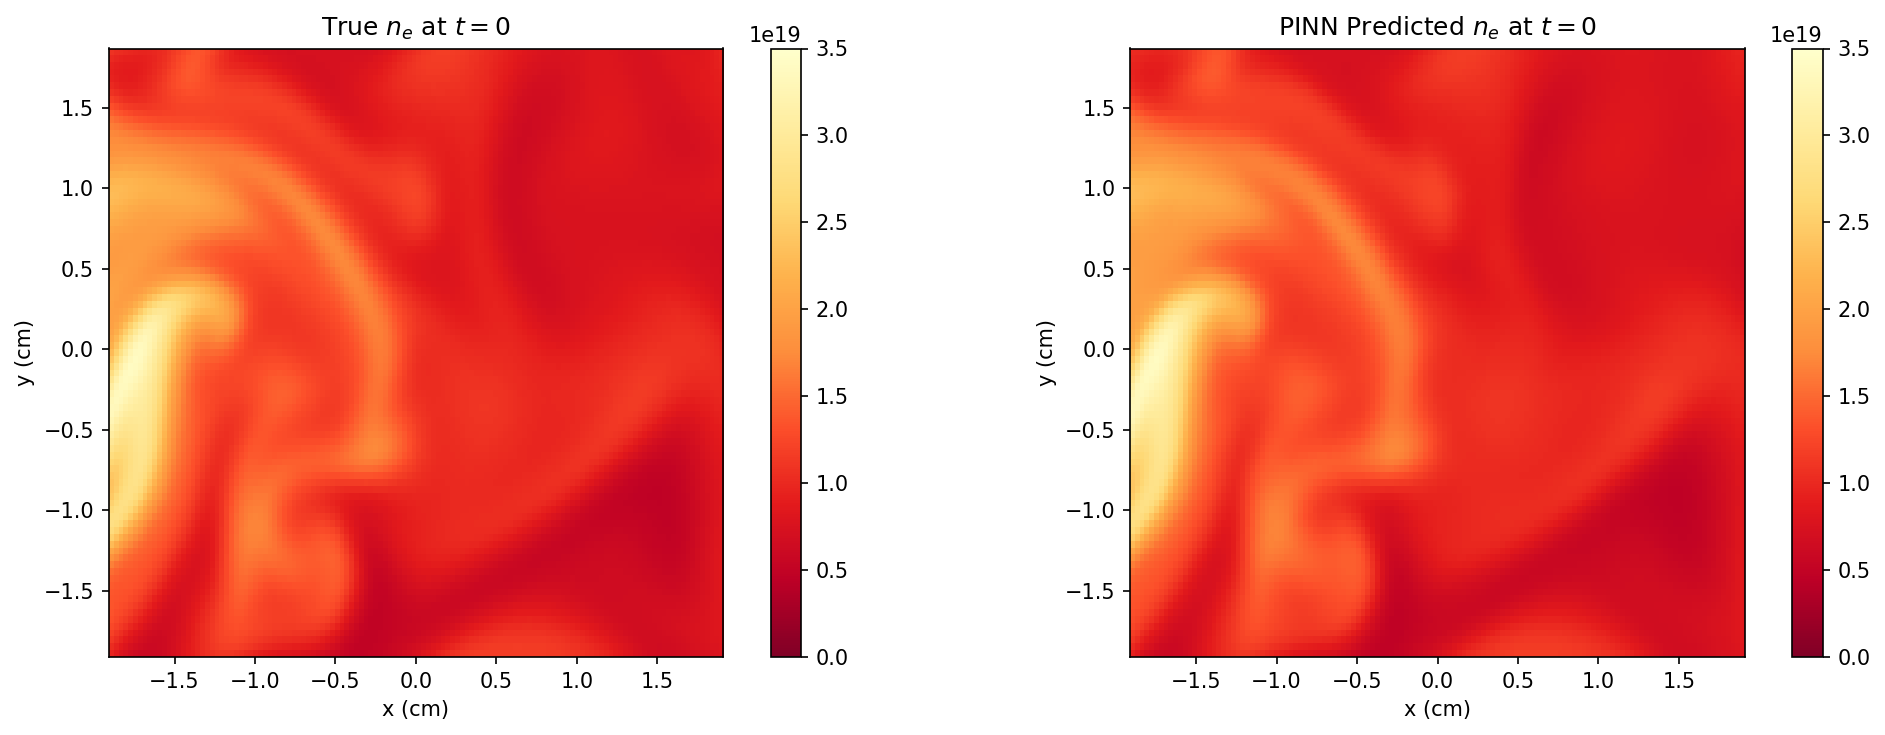

In [25]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from utils.constants import *
from pinn_setup import PINN
from config.settings import LAYERS  # Your MLP layer config

rcParams['figure.dpi'] = 150

EPOCHS = 15000

# === Grid and frame constants ===
DATA_FILE_NAME = 'data/plasma_data.h5'
NT = 4
NX, NY = 128, 89
N_FRAME = NX * NY
SPACE_FACTOR = 100.0 * MINOR_RADIUS  # cm

# === Load and reshape frame 0 ===
vec_to_mat = lambda vec: np.fliplr(vec.reshape(NX, NY, order='F')).T

with h5py.File(DATA_FILE_NAME, 'r') as f:
    frame_idxs = range(0, N_FRAME)
    den_frame0 = vec_to_mat(f['y_den'][frame_idxs]) * PLASMA_DENSITY
    x_grid = vec_to_mat(f['x_x'][frame_idxs]) * SPACE_FACTOR
    y_grid = vec_to_mat(f['x_y'][frame_idxs]) * SPACE_FACTOR

# === Prepare training data ===
t_fixed = 0.0  # Static time slice
x_vec = x_grid.T.flatten().reshape(-1, 1)
y_vec = y_grid.T.flatten().reshape(-1, 1)
t_vec = np.full_like(x_vec, t_fixed)
v1_vec = den_frame0.T.flatten().reshape(-1, 1)

# Convert to torch tensors
x_train = torch.tensor(x_vec, dtype=torch.float32)
y_train = torch.tensor(y_vec, dtype=torch.float32)
t_train = torch.tensor(t_vec, dtype=torch.float32)
v1_train = torch.tensor(v1_vec, dtype=torch.float32)
v5_train = torch.zeros_like(v1_train)  # dummy for PINN input

# === Normalize target (n_e) ===
v1_mean = v1_train.mean()
v1_std = v1_train.std()
v1_train_norm = (v1_train - v1_mean) / v1_std

# === Initialize PINN ===
model = PINN(x_train, y_train, t_train, v1_train_norm, v5_train, layers=LAYERS, use_pde=False)
model.setup_optimizers()
model.apply(model.xavier_init)

# === Train for a few epochs ===
loss_fn = torch.nn.MSELoss()
for epoch in range(EPOCHS):  # Few epochs for testing
    loss = model.train_step(loss_fn, model.optimizer_v1, model.optimizer_v5)
    if epoch % 2000 == 0:
        print(f"Epoch {epoch}: Loss = {loss['total']:.4e}")

# === Predict on full grid ===
with torch.no_grad():
    preds = model.predict(x_vec, y_vec, t_vec)
    v1_pred = preds['v1'] * v1_std.item() + v1_mean.item()
    v1_pred_grid = np.fliplr(v1_pred.reshape(NX, NY)).T

# === Plot truth vs. predicion ===
x_min = np.min(x_grid)
x_max = np.max(x_grid)
y_min = np.min(y_grid)
y_max = np.max(y_grid)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# True
im0 = axs[0].imshow(
    den_frame0,
    cmap='YlOrRd_r',
    vmin=0,
    vmax=3.5e19,
    extent=[x_min, x_max, y_min, y_max],
    aspect='equal'
)
axs[0].set_title("True $n_e$ at $t=0$")
axs[0].set_xlabel("x (cm)")
axs[0].set_ylabel("y (cm)")
plt.colorbar(im0, ax=axs[0])

# Predicted
im1 = axs[1].imshow(
    v1_pred_grid,
    origin='lower',
    cmap='YlOrRd_r',
    vmin=0,
    vmax=3.5e19,
    extent=[x_min, x_max, y_min, y_max],
    aspect='equal'
)
axs[1].set_title("PINN Predicted $n_e$ at $t=0$")
axs[1].set_xlabel("x (cm)")
axs[1].set_ylabel("y (cm)")
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()